In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
path = 'C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\Datasets\\(dimethylamino)propiophenone hydrochloride_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('\\')[-1]
drug_name = dr.split('_')[0]
drug_name

'(dimethylamino)propiophenone hydrochloride'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

In [6]:
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,1.93205,3.74886,0.452336,0.940899,2.78817,0.493042,1.21729,36.0483,2.49718,2.30652
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,1.96807,3.22352,0.157620,0.343406,2.11181,0.135277,1.42039,103.5290,1.27063,1.64715


In [7]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [8]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [9]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [10]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [11]:
X.shape

(52, 24023)

In [12]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [13]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [14]:
X.shape, y.shape

((52, 24023), (52,))

In [15]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    37
1    15
dtype: int64

In [16]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [17]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.108740,1.023634,-0.198422,0.048655,0.014083,0.057201,0.058435,-0.068479,2.466739,0.154698,...,-1.172696,-0.953126,-0.386856,-1.245871,0.939877,-1.279822,-0.362430,0.397980,-0.670559,1.252175
1,1.837347,0.169666,-0.336871,-0.226545,0.014083,-0.178379,0.058435,-0.068479,-0.936924,5.128888,...,-0.769675,-0.049522,-1.165318,0.000215,-0.950606,-1.123913,-1.068527,-2.149729,-1.622007,0.842070


In [18]:
X.shape, y.shape

((74, 24023), (74,))

In [19]:
y.value_counts()

1    37
0    37
dtype: int64

In [20]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.108740,1.023634,-0.198422,0.048655,0.014083,0.057201,0.058435,-0.068479,2.466739,0.154698,...,-1.172696,-0.953126,-0.386856,-1.245871,0.939877,-1.279822,-0.362430,0.397980,-0.670559,1.252175
1,1.837347,0.169666,-0.336871,-0.226545,0.014083,-0.178379,0.058435,-0.068479,-0.936924,5.128888,...,-0.769675,-0.049522,-1.165318,0.000215,-0.950606,-1.123913,-1.068527,-2.149729,-1.622007,0.842070


In [21]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [22]:
X_train.shape, X_test.shape

((59, 24023), (15, 24023))

In [23]:
y_train.value_counts(), y_test.value_counts()

(1    31
 0    28
 dtype: int64,
 0    9
 1    6
 dtype: int64)

In [24]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 638
Number of features selected during iteration 1: 643
Number of features selected during iteration 2: 652
Number of features selected during iteration 3: 626
Number of features selected during iteration 4: 645
Number of features selected during iteration 5: 630
Number of features selected during iteration 6: 635
Number of features selected during iteration 7: 662
Number of features selected during iteration 8: 657
Number of features selected during iteration 9: 636
Number of features selected during iteration 10: 648
Number of features selected during iteration 11: 633
Number of features selected during iteration 12: 654
Number of features selected during iteration 13: 650
Number of features selected during iteration 14: 640
Number of features selected during iteration 15: 652
Number of features selected during iteration 16: 659
Number of features selected during iteration 17: 658
Number of features selected during iteration 18: 632
Num

In [25]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(4, 638)

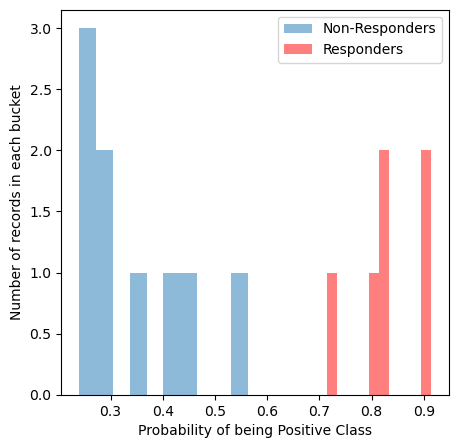

In [26]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [27]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [28]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.108740,1.023634,-0.198422,0.048655,0.014083,0.057201,0.058435,-0.068479,2.466739,0.154698,...,-0.386856,-1.245871,0.939877,-1.279822,-0.362430,0.397980,-0.670559,1.252175,NaN,NaN
1,1.837347,0.169666,-0.336871,-0.226545,0.014083,-0.178379,0.058435,-0.068479,-0.936924,5.128888,...,-1.165318,0.000215,-0.950606,-1.123913,-1.068527,-2.149729,-1.622007,0.842070,NaN,NaN
2,-0.646221,-1.019800,-0.393969,-0.227510,0.014083,-0.336770,0.058435,-0.588306,-1.028237,0.154698,...,0.080952,-1.095199,-0.105799,-1.152694,-0.217618,-0.502587,-0.546641,-0.209038,NaN,NaN
3,2.144711,0.716344,-0.408079,-0.228138,-0.499742,0.057201,0.058435,-0.420196,-0.701483,0.154698,...,-0.101121,-0.317535,0.411719,0.309081,-0.309843,-0.789255,0.706813,-0.854769,NaN,NaN
4,1.296433,-0.960352,-0.198422,-0.225953,0.014083,0.057201,0.058435,-0.338352,-0.951209,-0.007980,...,-1.259215,0.270892,-1.729092,1.333527,-2.012767,-0.620747,-1.105220,-0.044776,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-0.906895,0.016701,4.478023,-0.227927,-0.485475,-0.331310,0.058435,-0.451578,-1.066600,0.154698,...,0.825821,1.308294,-0.110276,0.636733,0.981448,0.599939,0.713038,-0.771420,NaN,NaN
70,0.647947,-0.457510,-0.352890,-0.162417,-0.421735,-0.236790,0.058435,-0.265883,-0.139492,-0.916381,...,0.822901,-1.142906,0.211855,-0.230133,0.328334,-0.726165,-0.049795,-0.283365,NaN,NaN
71,0.363750,-0.542952,-0.305141,-0.160124,0.014083,-0.248836,0.058435,-0.464894,-0.271464,-1.307288,...,-1.013464,-0.233382,-0.309314,-0.731548,-0.909609,-1.111008,-1.179601,-0.408724,NaN,NaN
72,0.051717,-0.544742,1.306241,-0.223111,0.282526,-0.170738,0.058435,3.651881,-0.417964,0.116459,...,-0.385876,0.457210,-1.051470,0.099635,-1.140443,-0.482536,-0.972081,0.286939,0.826133,1.0


In [29]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(1, 24025)

In [30]:
df1_main.index.values #0 40 41 42

array([39], dtype=int64)

In [31]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 666
Features selected during iteration 1: 638
Features selected during iteration 2: 643
Features selected during iteration 3: 666
Features selected during iteration 4: 646
Features selected during iteration 5: 667
Features selected during iteration 6: 647
Features selected during iteration 7: 659
Features selected during iteration 8: 642
Features selected during iteration 9: 650
Features selected during iteration 10: 652
Features selected during iteration 11: 642
Features selected during iteration 12: 682
Features selected during iteration 13: 632
Features selected during iteration 14: 654
Features selected during iteration 15: 651
Features selected during iteration 16: 636
Features selected during iteration 17: 653
Features selected during iteration 18: 669
Features selected during iteration 19: 662
Features selected during iteration 20: 669
Features selected during iteration 21: 659
Features selected during iteration 22: 649
Features selected dur

In [32]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 653.24


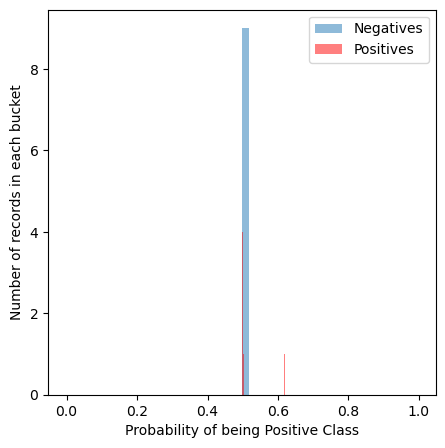

In [33]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [34]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [35]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [36]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [37]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 31
Features selected during iteration 1: 31
Features selected during iteration 2: 31
Features selected during iteration 3: 31
Features selected during iteration 4: 31
Features selected during iteration 5: 31
Features selected during iteration 6: 31
Features selected during iteration 7: 31
Features selected during iteration 8: 31
Features selected during iteration 9: 31
Features selected during iteration 10: 31
Features selected during iteration 11: 31
Features selected during iteration 12: 31
Features selected during iteration 13: 31
Features selected during iteration 14: 31
Features selected during iteration 15: 31
Features selected during iteration 16: 31
Features selected during iteration 17: 31
Features selected during iteration 18: 31
Features selected during iteration 19: 31
Features selected during iteration 20: 31
Features selected during iteration 21: 31
Features selected during iteration 22: 31
Features selected during iteration 23: 31
Fe

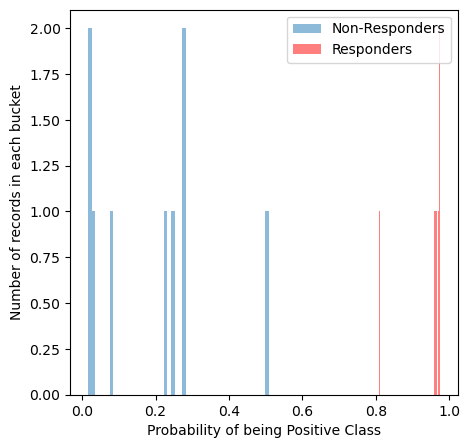

In [38]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [39]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.108740,1.023634,-0.198422,0.048655,0.014083,0.057201,0.058435,-0.068479,2.466739,0.154698,...,-0.386856,-1.245871,0.939877,-1.279822,-0.362430,0.397980,-0.670559,1.252175,NaN,NaN
1,1.837347,0.169666,-0.336871,-0.226545,0.014083,-0.178379,0.058435,-0.068479,-0.936924,5.128888,...,-1.165318,0.000215,-0.950606,-1.123913,-1.068527,-2.149729,-1.622007,0.842070,NaN,NaN
2,-0.646221,-1.019800,-0.393969,-0.227510,0.014083,-0.336770,0.058435,-0.588306,-1.028237,0.154698,...,0.080952,-1.095199,-0.105799,-1.152694,-0.217618,-0.502587,-0.546641,-0.209038,NaN,NaN
3,2.144711,0.716344,-0.408079,-0.228138,-0.499742,0.057201,0.058435,-0.420196,-0.701483,0.154698,...,-0.101121,-0.317535,0.411719,0.309081,-0.309843,-0.789255,0.706813,-0.854769,NaN,NaN
4,1.296433,-0.960352,-0.198422,-0.225953,0.014083,0.057201,0.058435,-0.338352,-0.951209,-0.007980,...,-1.259215,0.270892,-1.729092,1.333527,-2.012767,-0.620747,-1.105220,-0.044776,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-0.906895,0.016701,4.478023,-0.227927,-0.485475,-0.331310,0.058435,-0.451578,-1.066600,0.154698,...,0.825821,1.308294,-0.110276,0.636733,0.981448,0.599939,0.713038,-0.771420,NaN,NaN
70,0.647947,-0.457510,-0.352890,-0.162417,-0.421735,-0.236790,0.058435,-0.265883,-0.139492,-0.916381,...,0.822901,-1.142906,0.211855,-0.230133,0.328334,-0.726165,-0.049795,-0.283365,NaN,NaN
71,0.363750,-0.542952,-0.305141,-0.160124,0.014083,-0.248836,0.058435,-0.464894,-0.271464,-1.307288,...,-1.013464,-0.233382,-0.309314,-0.731548,-0.909609,-1.111008,-1.179601,-0.408724,NaN,NaN
72,0.051717,-0.544742,1.306241,-0.223111,0.282526,-0.170738,0.058435,3.651881,-0.417964,0.116459,...,-0.385876,0.457210,-1.051470,0.099635,-1.140443,-0.482536,-0.972081,0.286939,0.970699,1.0


In [40]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
39,-0.825537,-1.040448,-0.339032,-0.226425,0.014083,-0.346023,0.058435,-0.590783,-1.141028,-1.771567,...,-1.212454,0.088151,-0.706016,-0.557434,-1.083375,-1.590213,-1.341256,-0.936172,0.809357,1.0


In [41]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [42]:
cl = set(common_list)
cl

{39}

In [43]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
39,-0.825537,-1.040448,-0.339032,-0.226425,0.014083,-0.346023,0.058435,-0.590783,-1.141028,-1.771567,...,-1.212454,0.088151,-0.706016,-0.557434,-1.083375,-1.590213,-1.341256,-0.936172,0.714,1.0


In [44]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [46]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')